https://colab.research.google.com/drive/1mhigAe0uV_QQyBVz3y6QRv47GUkD9zRJ

# Step 2 : Editting the Skeleton

_"Great Models are built with even greater **skeletons**"_ --Successful Student

Target:

1. Get the basic skeleton right. We will try and avoid changing this skeleton as much as possible.
2. No fancy stuff
3. Results:
    1. Parameters: 194k
    2. Best Train Accuracy: 99.51
    3. Best Test Accuracy: 98.96
4. Analysis:
    1. The model is still large, but working.
    2. We see some over-fitting

## 1. Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## 2. Calculate Mean & Standard Deviation of Raw Data to Normalize the Input Data/Tensor Later

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\ProgramData\anaconda3\envs\python39\lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## 3.1 Record Some Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
cuda = torch.cuda.is_available()

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(exp, **dataloader_args)

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)
torch.Size([128, 1, 28, 28])
torch.Size([128])


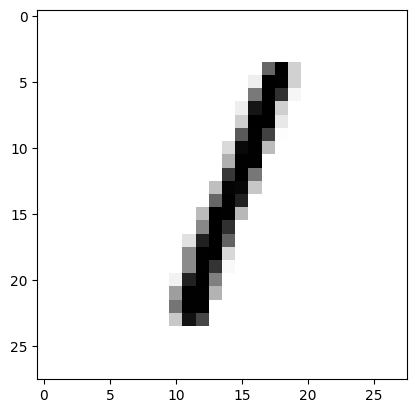

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = exp.train_data
train_data = exp.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## 3.2 A Bit MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

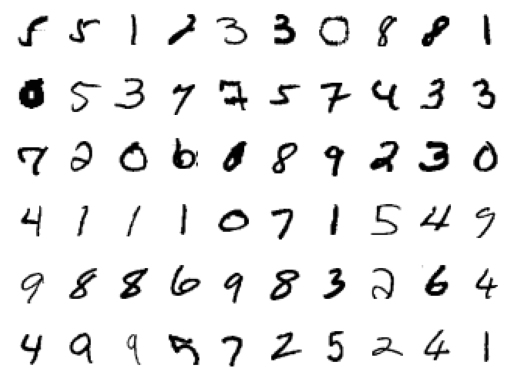

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## 4. Define your NN Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 28-26 | J in-out = 1-1 | R.F in-out = 1-3 |  | Channels in-out = 1-32

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 26-24 | J in-out = 1-1 | R.F in-out = 3-5 | Channels in-out = 32-64
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 24-22 | J in-out = 1-1 | R.F in-out = 5-7 | Channels in-out = 64-128

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # X in-out = 22-11 | J in-out = 1-2 | R.F in-out = 7-8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 11-11 | J in-out = 2-2 | R.F in-out = 8-8 | Channels in-out = 128-32

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 11-9 | J in-out = 2-2 | R.F in-out = 8-12 | Channels in-out = 32-64
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 9-7 | J in-out = 2-2 | R.F in-out = 12-16 | Channels in-out = 64-128

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # X in-out = 7-7 | J in-out = 2-2 | R.F in-out = 16-16 | Channels in-out = 128-10
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # GAP Layer : 7x7x10 C.V. over 7x7x10x10 = 1x1x10

    def forward(self, x):
        # INPUT BLOCK
        x = self.convblock1(x)

        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        x = self.convblock3(x)

        # MAXPOOL 1
        x = self.pool1(x)
        x = self.convblock4(x)

        # CONVOLUTION BLOCK 2
        x = self.convblock5(x)
        x = self.convblock6(x)

        # OUTPUT BLOCK
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)

## 5. Observe the Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,432
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,728
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 32, 11, 11]           4,096
              ReLU-9           [-1, 32, 11, 11]               0
           Conv2d-10             [-1, 64, 9, 9]          18,432
             ReLU-11             [-1, 64, 9, 9]               0
           Conv2d-12            [-1, 128, 7, 7]          73,728
             ReLU-13            [-1, 128, 7, 7]               0
           Conv2d-14             [-1, 1

## 6. SEED - finish randomness of PyTorch

Before we start training, get rid of PyTorch SEED Issue

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


## 7. Import & Define Train/Test Data with Normalized Tensors

1.   Define Appropriate Transformations
2.   Apply the Transformations to Input Dataset - both Train & Test


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## 8. Create Dataset Batches

In [ ]:

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

## 9. Define Training and Testing Methods for Neural Network

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Added due to use of GAP Layer
    # Reshape y_pred to (batch_size, num_classes) before calculating loss
    #y_pred = y_pred.view(y_pred.size(0), -1)  # Assuming y_pred is (batch_size, num_classes, 1, 1)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #output = output.view(output.size(0), -1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## 10. Run, Train and Test the Model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1358102709054947 Batch_id=468 Accuracy=76.29: 100%|███████████████████████████| 469/469 [00:22<00:00, 20.46it/s]



Test set: Average loss: 0.1552, Accuracy: 9508/10000 (95.08%)

EPOCH: 1


Loss=0.09103420376777649 Batch_id=468 Accuracy=96.04: 100%|██████████████████████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0948, Accuracy: 9706/10000 (97.06%)

EPOCH: 2


Loss=0.06789248436689377 Batch_id=468 Accuracy=97.25: 100%|██████████████████████████| 469/469 [00:22<00:00, 20.42it/s]



Test set: Average loss: 0.0687, Accuracy: 9772/10000 (97.72%)

EPOCH: 3


Loss=0.02091868966817856 Batch_id=468 Accuracy=97.78: 100%|██████████████████████████| 469/469 [00:25<00:00, 18.71it/s]



Test set: Average loss: 0.0570, Accuracy: 9813/10000 (98.13%)

EPOCH: 4


Loss=0.01647868938744068 Batch_id=468 Accuracy=98.27: 100%|██████████████████████████| 469/469 [00:24<00:00, 19.43it/s]



Test set: Average loss: 0.0535, Accuracy: 9823/10000 (98.23%)

EPOCH: 5


Loss=0.032800011336803436 Batch_id=468 Accuracy=98.47: 100%|█████████████████████████| 469/469 [00:24<00:00, 19.50it/s]



Test set: Average loss: 0.0440, Accuracy: 9858/10000 (98.58%)

EPOCH: 6


Loss=0.08385896682739258 Batch_id=468 Accuracy=98.66: 100%|██████████████████████████| 469/469 [00:23<00:00, 20.21it/s]



Test set: Average loss: 0.0459, Accuracy: 9856/10000 (98.56%)

EPOCH: 7


Loss=0.14516513049602509 Batch_id=468 Accuracy=98.72: 100%|██████████████████████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0411, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.03582369536161423 Batch_id=468 Accuracy=98.86: 100%|██████████████████████████| 469/469 [00:23<00:00, 19.84it/s]



Test set: Average loss: 0.0413, Accuracy: 9859/10000 (98.59%)

EPOCH: 9


Loss=0.05158239230513573 Batch_id=468 Accuracy=98.97: 100%|██████████████████████████| 469/469 [00:25<00:00, 18.29it/s]



Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.010673869401216507 Batch_id=468 Accuracy=99.05: 100%|█████████████████████████| 469/469 [00:24<00:00, 19.40it/s]



Test set: Average loss: 0.0448, Accuracy: 9849/10000 (98.49%)

EPOCH: 11


Loss=0.023403828963637352 Batch_id=468 Accuracy=99.12: 100%|█████████████████████████| 469/469 [00:24<00:00, 18.95it/s]



Test set: Average loss: 0.0332, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.014677523635327816 Batch_id=468 Accuracy=99.17: 100%|█████████████████████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0342, Accuracy: 9896/10000 (98.96%)

EPOCH: 13


Loss=0.041965678334236145 Batch_id=468 Accuracy=99.26: 100%|█████████████████████████| 469/469 [00:24<00:00, 19.25it/s]



Test set: Average loss: 0.0381, Accuracy: 9878/10000 (98.78%)

EPOCH: 14


Loss=0.010398528538644314 Batch_id=468 Accuracy=99.27: 100%|█████████████████████████| 469/469 [00:25<00:00, 18.73it/s]



Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)

EPOCH: 15


Loss=0.020674696192145348 Batch_id=468 Accuracy=99.32: 100%|█████████████████████████| 469/469 [00:24<00:00, 19.02it/s]



Test set: Average loss: 0.0430, Accuracy: 9875/10000 (98.75%)

EPOCH: 16


Loss=0.007706440985202789 Batch_id=468 Accuracy=99.41: 100%|█████████████████████████| 469/469 [00:23<00:00, 19.72it/s]



Test set: Average loss: 0.0389, Accuracy: 9873/10000 (98.73%)

EPOCH: 17


Loss=0.0020083945710211992 Batch_id=468 Accuracy=99.44: 100%|████████████████████████| 469/469 [00:23<00:00, 19.88it/s]



Test set: Average loss: 0.0384, Accuracy: 9877/10000 (98.77%)

EPOCH: 18


Loss=0.0013046055100858212 Batch_id=468 Accuracy=99.51: 100%|████████████████████████| 469/469 [00:23<00:00, 19.75it/s]



Test set: Average loss: 0.0362, Accuracy: 9894/10000 (98.94%)

EPOCH: 19


Loss=0.0015533971600234509 Batch_id=468 Accuracy=99.50: 100%|████████████████████████| 469/469 [00:23<00:00, 19.57it/s]



Test set: Average loss: 0.0380, Accuracy: 9888/10000 (98.88%)



In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")